In [3]:
%matplotlib inline
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt

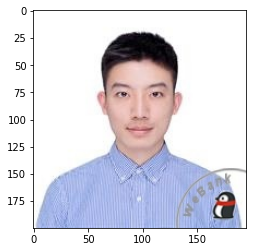

In [20]:
boxes = [50, 25, 140, 140]

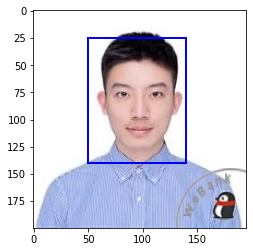

In [21]:
img = plt.imread('wxy.jpg')
fig = plt.imshow(img)
fig.axes.add_patch(d2l.bbox_to_rect(boxes, 'blue'))

In [35]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = d2l.tensor(sizes, device=device)
    ratio_tensor = d2l.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))

    # print

    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack(
        (-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [42]:
data = torch.randn(1, 3, 2, 3)
sizes = [0.25, 0.5]
ratios = [1, 2]

In [55]:
multibox_prior(data, sizes=sizes, ratios=ratios).shape

tensor([0.2500, 0.2500, 0.2500, 0.7500, 0.7500, 0.7500])
tensor([0.1667, 0.5000, 0.8333, 0.1667, 0.5000, 0.8333])


torch.Size([1, 18, 4])

In [56]:
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [88]:
boxes1 = torch.tensor([[1, 1, 5, 5], [3, 3, 6, 6]])
boxes2 = torch.tensor([[2, 2, 6, 6]])
print(boxes1)
print(boxes2)

tensor([[1, 1, 5, 5],
        [3, 3, 6, 6]])
tensor([[2, 2, 6, 6]])


In [99]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [105]:
anchors_bbox_map = torch.full((18,), -1, dtype=torch.long)

In [107]:
jaccard = torch.randn(2, 3)
max_ious, indices = torch.max(jaccard, dim=1)

In [113]:
torch.max(jaccard, dim=1)

torch.return_types.max(
values=tensor([-0.8089, -0.0212]),
indices=tensor([0, 0]))

In [114]:
jaccard

tensor([[-0.8089, -1.6433, -1.4675],
        [-0.0212, -0.2711, -1.2630]])

In [117]:
a = torch.randn(2, 3)
b = torch.ones(2, 3)

In [118]:
torch.cat([a, b], dim=1)

tensor([[-2.0880, -2.6531, -2.5494,  1.0000,  1.0000,  1.0000],
        [ 0.4520, -0.5722,  0.5635,  1.0000,  1.0000,  1.0000]])